In [1]:
! pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kagglehub]/4 [kagglehub]


In [4]:
import kagglehub
import shutil
import os

# Step 1: Download (Kaggle-controlled location)
src_path = kagglehub.dataset_download("mohamedadlyi/aflw2000-3d")

# Step 2: Move / copy to your desired folder
dst_path = "../dataset/aflw2000-3d"
os.makedirs(dst_path, exist_ok=True)

shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset copied to:", dst_path)

Dataset copied to: ../dataset/aflw2000-3d


In [1]:
import sys
import os

ROOT_DIR = os.path.abspath("..")
sys.path.append(ROOT_DIR)

In [14]:
import yaml

def load_cfg(cfg_fp):
    with open(cfg_fp, "r") as f:
        return yaml.safe_load(f)


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp

from TDDFA import TDDFA
from FaceBoxes import FaceBoxes
from utils.tddfa_util import _parse_param

# ---------------------------
# Config
# ---------------------------
IMG_DIR = "../dataset/aflw2000-3d/AFLW2000"
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Init models
# ---------------------------
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True
)

tddfa = TDDFA(
    gpu_mode=True,
    arch="mobilenet",
    checkpoint_fp="../weights/mb1_120x120.pth"
)

face_boxes = FaceBoxes()

# ---------------------------
# Storage
# ---------------------------
all_landmarks = []
all_expr = []

# ---------------------------
# Process images
# ---------------------------
for img_name in tqdm(os.listdir(IMG_DIR)):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue

    img_fp = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_fp)
    if img is None:
        continue

    h, w, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # MediaPipe landmarks
    results = mp_face.process(img_rgb)
    if not results.multi_face_landmarks:
        continue

    lm = results.multi_face_landmarks[0].landmark
    lm = np.array([[p.x * w, p.y * h, p.z * w] for p in lm]).flatten()
    all_landmarks.append(lm)

    # 3DDFA expression
    boxes = face_boxes(img)
    if len(boxes) == 0:
        all_landmarks.pop()
        continue

    param_lst, roi_box_lst = tddfa(img, [boxes[0]])
    _, _, _, alpha_exp = _parse_param(param_lst[0])
    all_expr.append(alpha_exp)

# ---------------------------
# Save
# ---------------------------
np.save(os.path.join(OUT_DIR, "landmarks.npy"), np.array(all_landmarks))
np.save(os.path.join(OUT_DIR, "expressions.npy"), np.array(all_expr))

print("Dataset created:")
print("Landmarks:", np.array(all_landmarks).shape)
print("Expressions:", np.array(all_expr).shape)


In [37]:
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
import mediapipe as mp
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)
def extract_landmarks(image):
    results = mp_face.process(image)
    if not results.multi_face_landmarks:
        return None

    lm = results.multi_face_landmarks[0].landmark
    coords = np.array([[p.x, p.y, p.z] for p in lm])  # (468, 3)
    return coords

I0000 00:00:1767962916.566924   21748 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1767962916.585550   40549 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon(TM) Graphics)


W0000 00:00:1767962916.591533   40536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1767962916.612884   40535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
class ExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])


In [42]:
train_ds = ExpressionDataset(X_train, y_train)
val_ds   = ExpressionDataset(X_val, y_val)


In [43]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [63]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# -------------------------------
# Config
# -------------------------------
DATA_DIR = "data"
LANDMARKS_FP = os.path.join(DATA_DIR, "landmarks.npy")
EXPRESSIONS_FP = os.path.join(DATA_DIR, "expressions.npy")
EPOCHS = 200
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
torch.set_grad_enabled(True)


class ExpressionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(478 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------------
# Training
# -------------------------------
model = ExpressionHead().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR ,weight_decay=1e-5)

best_val_loss = float("inf")

train_losses = []
val_losses   = []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    total_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validate ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.6f}, val_loss={avg_val_loss:.6f}")

    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "expr_head_best.pth"))
        print(f"🔥 New best model saved @ epoch {epoch+1}")

# Final save
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "expr_head_final.pth"))
print("Training done!")

Epoch 1/200 [Train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 344.41it/s]


Epoch 1: train_loss=0.394317, val_loss=0.331366
🔥 New best model saved @ epoch 1


Epoch 2/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 402.07it/s]


Epoch 2: train_loss=0.296122, val_loss=0.305031
🔥 New best model saved @ epoch 2


Epoch 3/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 499.92it/s]


Epoch 3: train_loss=0.226595, val_loss=0.219353
🔥 New best model saved @ epoch 3


Epoch 4/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 548.01it/s]


Epoch 4: train_loss=0.177672, val_loss=1.334629


Epoch 5/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 442.45it/s]


Epoch 5: train_loss=0.140032, val_loss=0.153900
🔥 New best model saved @ epoch 5


Epoch 6/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 498.18it/s]


Epoch 6: train_loss=0.121385, val_loss=0.148619
🔥 New best model saved @ epoch 6


Epoch 7/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 559.69it/s]


Epoch 7: train_loss=0.108642, val_loss=0.153332


Epoch 8/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 348.19it/s]


Epoch 8: train_loss=0.101355, val_loss=0.185931


Epoch 9/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 443.58it/s]


Epoch 9: train_loss=0.092519, val_loss=0.167446


Epoch 10/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 361.11it/s]


Epoch 10: train_loss=0.089695, val_loss=0.196493


Epoch 11/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 449.17it/s]


Epoch 11: train_loss=0.092651, val_loss=0.150250


Epoch 12/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 430.94it/s]


Epoch 12: train_loss=0.084436, val_loss=0.133921
🔥 New best model saved @ epoch 12


Epoch 13/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 494.88it/s]


Epoch 13: train_loss=0.086864, val_loss=0.119348
🔥 New best model saved @ epoch 13


Epoch 14/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 498.37it/s]


Epoch 14: train_loss=0.084836, val_loss=0.125843


Epoch 15/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 512.38it/s]


Epoch 15: train_loss=0.081285, val_loss=0.299904


Epoch 16/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 405.53it/s]


Epoch 16: train_loss=0.083643, val_loss=0.235553


Epoch 17/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 536.20it/s]


Epoch 17: train_loss=0.081925, val_loss=0.248067


Epoch 18/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 549.69it/s]


Epoch 18: train_loss=0.082368, val_loss=0.828141


Epoch 19/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 412.47it/s]


Epoch 19: train_loss=0.081394, val_loss=0.186758


Epoch 20/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 574.77it/s]


Epoch 20: train_loss=0.077610, val_loss=0.175296


Epoch 21/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 545.71it/s]


Epoch 21: train_loss=0.079153, val_loss=0.165151


Epoch 22/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 545.92it/s]


Epoch 22: train_loss=0.076356, val_loss=0.121858


Epoch 23/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 664.99it/s]


Epoch 23: train_loss=0.081027, val_loss=0.100473
🔥 New best model saved @ epoch 23


Epoch 24/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 512.29it/s]


Epoch 24: train_loss=0.074090, val_loss=0.180864


Epoch 25/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 521.59it/s]


Epoch 25: train_loss=0.072447, val_loss=0.101923


Epoch 26/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 605.21it/s]


Epoch 26: train_loss=0.074618, val_loss=0.103037


Epoch 27/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 276.51it/s]


Epoch 27: train_loss=0.075593, val_loss=0.116255


Epoch 28/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 637.76it/s]


Epoch 28: train_loss=0.072791, val_loss=0.098893
🔥 New best model saved @ epoch 28


Epoch 29/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 374.68it/s]


Epoch 29: train_loss=0.077046, val_loss=0.224915


Epoch 30/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 425.89it/s]


Epoch 30: train_loss=0.074452, val_loss=0.124404


Epoch 31/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 343.22it/s]


Epoch 31: train_loss=0.070566, val_loss=0.171781


Epoch 32/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 465.81it/s]


Epoch 32: train_loss=0.070509, val_loss=0.100237


Epoch 33/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 570.68it/s]


Epoch 33: train_loss=0.071499, val_loss=0.096943
🔥 New best model saved @ epoch 33


Epoch 34/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 308.81it/s]


Epoch 34: train_loss=0.071118, val_loss=0.154134


Epoch 35/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 573.54it/s]


Epoch 35: train_loss=0.070721, val_loss=0.111604


Epoch 36/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 357.11it/s]


Epoch 36: train_loss=0.072614, val_loss=0.109367


Epoch 37/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 352.35it/s]


Epoch 37: train_loss=0.070045, val_loss=0.352758


Epoch 38/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 661.94it/s]


Epoch 38: train_loss=0.068447, val_loss=0.088158
🔥 New best model saved @ epoch 38


Epoch 39/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 573.91it/s]


Epoch 39: train_loss=0.074032, val_loss=0.124081


Epoch 40/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 556.40it/s]


Epoch 40: train_loss=0.070267, val_loss=0.201750


Epoch 41/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 562.31it/s]


Epoch 41: train_loss=0.067994, val_loss=0.106226


Epoch 42/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 638.63it/s]


Epoch 42: train_loss=0.066511, val_loss=0.102838


Epoch 43/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 598.82it/s]


Epoch 43: train_loss=0.066996, val_loss=0.088266


Epoch 44/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 340.98it/s]


Epoch 44: train_loss=0.065213, val_loss=0.108262


Epoch 45/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 456.96it/s]


Epoch 45: train_loss=0.066993, val_loss=0.198334


Epoch 46/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 335.36it/s]


Epoch 46: train_loss=0.065607, val_loss=0.087659
🔥 New best model saved @ epoch 46


Epoch 47/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 621.84it/s]


Epoch 47: train_loss=0.066689, val_loss=0.110498


Epoch 48/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 454.91it/s]


Epoch 48: train_loss=0.066772, val_loss=0.103625


Epoch 49/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 618.99it/s]


Epoch 49: train_loss=0.064268, val_loss=0.115290


Epoch 50/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 342.20it/s]


Epoch 50: train_loss=0.065541, val_loss=0.115876


Epoch 51/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 347.85it/s]


Epoch 51: train_loss=0.063262, val_loss=0.091293


Epoch 52/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 317.69it/s]


Epoch 52: train_loss=0.063987, val_loss=0.134266


Epoch 53/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 327.95it/s]


Epoch 53: train_loss=0.062748, val_loss=0.122253


Epoch 54/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 552.46it/s]


Epoch 54: train_loss=0.062636, val_loss=0.135891


Epoch 55/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 355.07it/s]


Epoch 55: train_loss=0.063905, val_loss=0.094887


Epoch 56/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 516.71it/s]


Epoch 56: train_loss=0.064638, val_loss=0.176455


Epoch 57/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 436.60it/s]


Epoch 57: train_loss=0.064373, val_loss=0.176211


Epoch 58/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 332.18it/s]


Epoch 58: train_loss=0.062224, val_loss=0.099062


Epoch 59/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 347.33it/s]


Epoch 59: train_loss=0.063505, val_loss=0.168054


Epoch 60/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 347.76it/s]


Epoch 60: train_loss=0.062329, val_loss=0.132166


Epoch 61/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 412.73it/s]


Epoch 61: train_loss=0.064380, val_loss=0.254897


Epoch 62/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 332.81it/s]


Epoch 62: train_loss=0.062375, val_loss=0.139551


Epoch 63/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 514.64it/s]


Epoch 63: train_loss=0.061549, val_loss=0.085280
🔥 New best model saved @ epoch 63


Epoch 64/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 540.06it/s]


Epoch 64: train_loss=0.062867, val_loss=0.179190


Epoch 65/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 498.47it/s]


Epoch 65: train_loss=0.061313, val_loss=0.118817


Epoch 66/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 670.23it/s]


Epoch 66: train_loss=0.062119, val_loss=0.165898


Epoch 67/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 356.04it/s]


Epoch 67: train_loss=0.062048, val_loss=0.136489


Epoch 68/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 549.78it/s]


Epoch 68: train_loss=0.061354, val_loss=0.145309


Epoch 69/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 355.84it/s]


Epoch 69: train_loss=0.061084, val_loss=0.174784


Epoch 70/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 349.32it/s]


Epoch 70: train_loss=0.062100, val_loss=0.080540
🔥 New best model saved @ epoch 70


Epoch 71/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 322.85it/s]


Epoch 71: train_loss=0.061520, val_loss=0.148135


Epoch 72/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 540.55it/s]


Epoch 72: train_loss=0.061181, val_loss=0.246378


Epoch 73/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 563.30it/s]


Epoch 73: train_loss=0.059759, val_loss=0.165771


Epoch 74/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 526.83it/s]


Epoch 74: train_loss=0.059175, val_loss=0.094661


Epoch 75/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 549.21it/s]


Epoch 75: train_loss=0.059569, val_loss=0.275332


Epoch 76/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 575.17it/s]


Epoch 76: train_loss=0.059881, val_loss=0.176991


Epoch 77/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 581.28it/s]


Epoch 77: train_loss=0.058575, val_loss=0.086222


Epoch 78/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 560.84it/s]


Epoch 78: train_loss=0.059239, val_loss=0.321790


Epoch 79/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 591.72it/s]


Epoch 79: train_loss=0.056764, val_loss=0.231450


Epoch 80/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 625.64it/s]


Epoch 80: train_loss=0.062918, val_loss=0.098655


Epoch 81/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 518.88it/s]


Epoch 81: train_loss=0.060299, val_loss=0.305975


Epoch 82/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 558.47it/s]


Epoch 82: train_loss=0.059975, val_loss=0.192841


Epoch 83/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 557.14it/s]


Epoch 83: train_loss=0.057917, val_loss=0.148052


Epoch 84/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 443.50it/s]


Epoch 84: train_loss=0.056940, val_loss=0.253207


Epoch 85/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 526.46it/s]


Epoch 85: train_loss=0.056881, val_loss=0.098567


Epoch 86/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 621.59it/s]


Epoch 86: train_loss=0.058170, val_loss=0.162162


Epoch 87/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 574.80it/s]


Epoch 87: train_loss=0.057544, val_loss=0.189785


Epoch 88/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 590.33it/s]


Epoch 88: train_loss=0.057748, val_loss=0.165308


Epoch 89/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 373.32it/s]


Epoch 89: train_loss=0.056304, val_loss=0.093309


Epoch 90/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 354.21it/s]


Epoch 90: train_loss=0.056235, val_loss=0.156063


Epoch 91/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 333.23it/s]


Epoch 91: train_loss=0.059028, val_loss=0.148532


Epoch 92/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 557.58it/s]


Epoch 92: train_loss=0.057997, val_loss=0.095574


Epoch 93/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 383.01it/s]


Epoch 93: train_loss=0.056108, val_loss=0.171472


Epoch 94/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 308.19it/s]


Epoch 94: train_loss=0.054925, val_loss=0.100872


Epoch 95/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 563.75it/s]


Epoch 95: train_loss=0.055249, val_loss=0.129360


Epoch 96/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 606.52it/s]


Epoch 96: train_loss=0.055114, val_loss=0.110294


Epoch 97/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 385.52it/s]


Epoch 97: train_loss=0.055711, val_loss=0.089351


Epoch 98/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 557.95it/s]


Epoch 98: train_loss=0.055855, val_loss=0.086675


Epoch 99/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 352.35it/s]


Epoch 99: train_loss=0.056792, val_loss=0.141646


Epoch 100/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 367.58it/s]


Epoch 100: train_loss=0.054356, val_loss=0.112873


Epoch 101/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 353.75it/s]


Epoch 101: train_loss=0.054819, val_loss=0.127802


Epoch 102/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 425.98it/s]


Epoch 102: train_loss=0.052672, val_loss=0.150246


Epoch 103/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 564.28it/s]


Epoch 103: train_loss=0.053630, val_loss=0.133037


Epoch 104/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 356.40it/s]


Epoch 104: train_loss=0.053801, val_loss=0.109559


Epoch 105/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 347.41it/s]


Epoch 105: train_loss=0.052630, val_loss=0.180364


Epoch 106/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 360.87it/s]


Epoch 106: train_loss=0.056230, val_loss=0.099821


Epoch 107/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 355.20it/s]


Epoch 107: train_loss=0.055383, val_loss=0.102312


Epoch 108/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 354.57it/s]


Epoch 108: train_loss=0.052990, val_loss=0.106988


Epoch 109/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 588.65it/s]


Epoch 109: train_loss=0.055381, val_loss=0.133036


Epoch 110/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 347.58it/s]


Epoch 110: train_loss=0.050321, val_loss=0.125313


Epoch 111/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 565.07it/s]


Epoch 111: train_loss=0.053383, val_loss=0.080949


Epoch 112/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 474.83it/s]


Epoch 112: train_loss=0.053816, val_loss=0.209289


Epoch 113/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 422.10it/s]


Epoch 113: train_loss=0.051005, val_loss=0.113007


Epoch 114/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 469.39it/s]


Epoch 114: train_loss=0.053860, val_loss=0.133785


Epoch 115/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 509.04it/s]


Epoch 115: train_loss=0.051404, val_loss=0.090026


Epoch 116/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 344.19it/s]


Epoch 116: train_loss=0.055864, val_loss=0.190750


Epoch 117/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 349.71it/s]


Epoch 117: train_loss=0.054172, val_loss=0.130599


Epoch 118/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 553.87it/s]


Epoch 118: train_loss=0.053070, val_loss=0.192772


Epoch 119/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 504.18it/s]


Epoch 119: train_loss=0.052596, val_loss=0.181624


Epoch 120/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 527.41it/s]


Epoch 120: train_loss=0.054943, val_loss=0.085587


Epoch 121/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 329.69it/s]


Epoch 121: train_loss=0.050890, val_loss=0.102783


Epoch 122/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 323.69it/s]


Epoch 122: train_loss=0.055832, val_loss=0.114942


Epoch 123/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 332.92it/s]


Epoch 123: train_loss=0.054444, val_loss=0.135237


Epoch 124/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 361.44it/s]


Epoch 124: train_loss=0.052496, val_loss=0.122994


Epoch 125/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 327.20it/s]


Epoch 125: train_loss=0.051695, val_loss=0.098055


Epoch 126/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 336.06it/s]


Epoch 126: train_loss=0.053404, val_loss=0.269924


Epoch 127/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 322.82it/s]


Epoch 127: train_loss=0.051689, val_loss=0.158121


Epoch 128/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 551.93it/s]


Epoch 128: train_loss=0.054622, val_loss=0.117524


Epoch 129/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 363.69it/s]


Epoch 129: train_loss=0.053984, val_loss=0.126294


Epoch 130/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 341.88it/s]


Epoch 130: train_loss=0.052349, val_loss=0.124317


Epoch 131/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 480.30it/s]


Epoch 131: train_loss=0.050953, val_loss=0.102792


Epoch 132/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 539.23it/s]


Epoch 132: train_loss=0.048806, val_loss=0.093332


Epoch 133/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 370.53it/s]


Epoch 133: train_loss=0.051757, val_loss=0.118946


Epoch 134/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 564.81it/s]


Epoch 134: train_loss=0.049596, val_loss=0.083962


Epoch 135/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 312.46it/s]


Epoch 135: train_loss=0.048065, val_loss=0.116840


Epoch 136/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 374.52it/s]


Epoch 136: train_loss=0.051423, val_loss=0.108939


Epoch 137/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 551.04it/s]


Epoch 137: train_loss=0.048590, val_loss=0.135329


Epoch 138/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 361.68it/s]


Epoch 138: train_loss=0.050320, val_loss=0.167760


Epoch 139/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 331.55it/s]


Epoch 139: train_loss=0.049281, val_loss=0.183066


Epoch 140/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 363.85it/s]


Epoch 140: train_loss=0.048161, val_loss=0.117594


Epoch 141/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 360.08it/s]


Epoch 141: train_loss=0.049686, val_loss=0.100149


Epoch 142/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 282.10it/s]


Epoch 142: train_loss=0.050448, val_loss=0.100613


Epoch 143/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 360.80it/s]


Epoch 143: train_loss=0.048700, val_loss=0.124658


Epoch 144/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 532.95it/s]


Epoch 144: train_loss=0.049604, val_loss=0.089469


Epoch 145/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 294.18it/s]


Epoch 145: train_loss=0.049048, val_loss=0.110782


Epoch 146/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 340.06it/s]


Epoch 146: train_loss=0.050424, val_loss=0.122366


Epoch 147/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 584.82it/s]


Epoch 147: train_loss=0.047757, val_loss=0.109396


Epoch 148/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 245.94it/s]


Epoch 148: train_loss=0.048320, val_loss=0.123458


Epoch 149/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 372.17it/s]


Epoch 149: train_loss=0.049739, val_loss=0.098430


Epoch 150/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 333.45it/s]


Epoch 150: train_loss=0.046647, val_loss=0.163483


Epoch 151/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 492.02it/s]


Epoch 151: train_loss=0.050979, val_loss=0.099480


Epoch 152/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 466.40it/s]


Epoch 152: train_loss=0.047533, val_loss=0.141369


Epoch 153/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 537.39it/s]


Epoch 153: train_loss=0.049706, val_loss=0.123016


Epoch 154/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 317.78it/s]


Epoch 154: train_loss=0.049412, val_loss=0.235164


Epoch 155/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 360.19it/s]


Epoch 155: train_loss=0.046989, val_loss=0.395198


Epoch 156/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 342.85it/s]


Epoch 156: train_loss=0.049312, val_loss=0.106978


Epoch 157/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 350.96it/s]


Epoch 157: train_loss=0.049663, val_loss=0.140592


Epoch 158/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 527.34it/s]


Epoch 158: train_loss=0.048780, val_loss=0.228966


Epoch 159/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 533.31it/s]


Epoch 159: train_loss=0.048029, val_loss=0.111736


Epoch 160/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 360.71it/s]


Epoch 160: train_loss=0.045184, val_loss=0.155452


Epoch 161/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 273.03it/s]


Epoch 161: train_loss=0.045165, val_loss=0.087795


Epoch 162/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 497.35it/s]


Epoch 162: train_loss=0.048256, val_loss=0.140404


Epoch 163/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 489.61it/s]


Epoch 163: train_loss=0.048272, val_loss=0.141071


Epoch 164/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 411.68it/s]


Epoch 164: train_loss=0.049559, val_loss=0.231505


Epoch 165/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 492.44it/s]


Epoch 165: train_loss=0.050336, val_loss=0.112638


Epoch 166/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 366.34it/s]


Epoch 166: train_loss=0.048544, val_loss=0.081285


Epoch 167/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 480.91it/s]


Epoch 167: train_loss=0.045588, val_loss=0.206930


Epoch 168/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 276.97it/s]


Epoch 168: train_loss=0.046758, val_loss=0.091402


Epoch 169/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 466.83it/s]


Epoch 169: train_loss=0.046149, val_loss=0.168347


Epoch 170/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 526.66it/s]


Epoch 170: train_loss=0.046191, val_loss=0.120145


Epoch 171/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 421.47it/s]


Epoch 171: train_loss=0.047398, val_loss=0.119735


Epoch 172/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 442.62it/s]


Epoch 172: train_loss=0.045810, val_loss=0.135093


Epoch 173/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 424.77it/s]


Epoch 173: train_loss=0.045470, val_loss=0.089187


Epoch 174/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 427.87it/s]


Epoch 174: train_loss=0.045197, val_loss=0.107713


Epoch 175/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 426.63it/s]


Epoch 175: train_loss=0.045715, val_loss=0.121183


Epoch 176/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 417.90it/s]


Epoch 176: train_loss=0.044222, val_loss=0.181965


Epoch 177/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 404.13it/s]


Epoch 177: train_loss=0.042935, val_loss=0.104457


Epoch 178/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 270.69it/s]


Epoch 178: train_loss=0.045105, val_loss=0.095496


Epoch 179/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 325.30it/s]


Epoch 179: train_loss=0.046381, val_loss=0.130597


Epoch 180/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 314.56it/s]


Epoch 180: train_loss=0.046386, val_loss=0.201231


Epoch 181/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 274.89it/s]


Epoch 181: train_loss=0.045063, val_loss=0.142250


Epoch 182/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 330.56it/s]


Epoch 182: train_loss=0.043344, val_loss=0.094062


Epoch 183/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 366.84it/s]


Epoch 183: train_loss=0.044296, val_loss=0.103632


Epoch 184/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 274.04it/s]


Epoch 184: train_loss=0.046137, val_loss=0.086030


Epoch 185/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 501.31it/s]


Epoch 185: train_loss=0.043744, val_loss=0.090394


Epoch 186/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 322.97it/s]


Epoch 186: train_loss=0.045200, val_loss=0.182688


Epoch 187/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 607.22it/s]


Epoch 187: train_loss=0.046626, val_loss=0.122079


Epoch 188/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 319.63it/s]


Epoch 188: train_loss=0.043062, val_loss=0.112290


Epoch 189/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 490.05it/s]


Epoch 189: train_loss=0.045375, val_loss=0.234686


Epoch 190/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 419.54it/s]


Epoch 190: train_loss=0.045934, val_loss=0.105665


Epoch 191/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 296.82it/s]


Epoch 191: train_loss=0.042669, val_loss=0.138125


Epoch 192/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 261.80it/s]


Epoch 192: train_loss=0.042434, val_loss=0.170653


Epoch 193/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 302.39it/s]


Epoch 193: train_loss=0.043309, val_loss=0.081381


Epoch 194/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 299.13it/s]


Epoch 194: train_loss=0.045340, val_loss=0.135090


Epoch 195/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 241.35it/s]


Epoch 195: train_loss=0.044029, val_loss=0.097116


Epoch 196/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 290.11it/s]


Epoch 196: train_loss=0.044280, val_loss=0.110286


Epoch 197/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 383.23it/s]


Epoch 197: train_loss=0.044227, val_loss=0.103135


Epoch 198/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 326.18it/s]


Epoch 198: train_loss=0.046020, val_loss=0.091827


Epoch 199/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 374.88it/s]


Epoch 199: train_loss=0.044963, val_loss=0.166226


Epoch 200/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 348.91it/s]

Epoch 200: train_loss=0.042057, val_loss=0.101688
Training done!


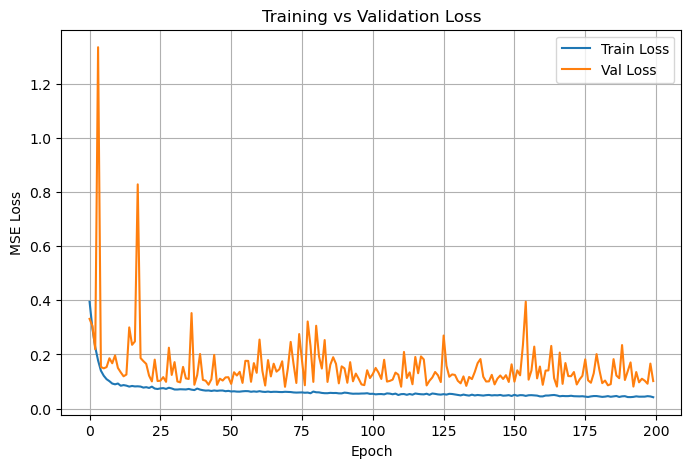

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)


In [67]:
ds = ExpressionDataset(X, y)
loader = DataLoader(ds, batch_size=128, shuffle=True)



======== GLOBAL METRICS ========
MSE  : 0.072102
MAE  : 0.142405
RMSE : 0.268518
R²   : 0.529377

---- Per Parameter MSE ----
Param 0: 0.305496
Param 1: 0.331241
Param 2: 0.022735
Param 3: 0.029908
Param 4: 0.001116
Param 5: 0.005972
Param 6: 0.007813
Param 7: 0.010833
Param 8: 0.000486
Param 9: 0.005419

Mean per-image MSE: 0.07210172
Worst sample MSE: 1.9000235


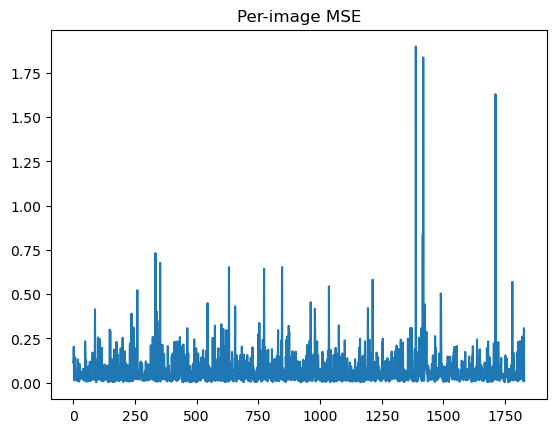

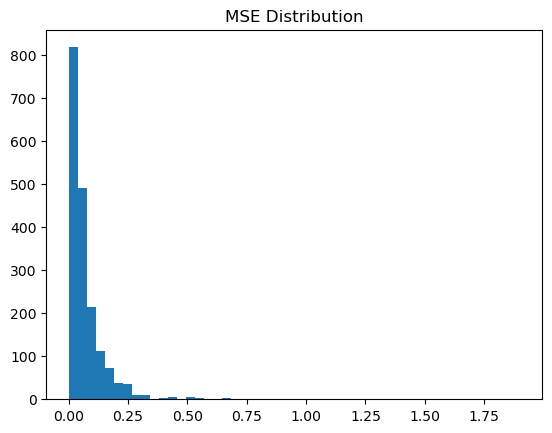

Saved per_image_mse.npy


In [71]:
from sklearn.metrics import mean_absolute_error, r2_score
MODEL_PATH = "./checkpoints/expr_head_final.pth"
# -------------------------------
# Data
# -------------------------------
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)

assert X.shape[0] == y.shape[0]
assert X.shape[1] == 478 * 3
assert y.shape[1] == 10

# -------------------------------
# Dataset + Dataloader
# -------------------------------
class ExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # index error safety
        idx = idx % len(self.X)
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

ds = ExpressionDataset(X, y)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------
# Load model
# -------------------------------
model = ExpressionHead().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# -------------------------------
# Inference loop
# -------------------------------
all_preds = []
all_gts = []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        yp = model(xb).cpu().numpy()

        all_preds.append(yp)
        all_gts.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_gts = np.concatenate(all_gts,  axis=0)

# -------------------------------
# Metrics
# -------------------------------
mse  = ((all_preds - all_gts)**2).mean()
mae  = np.abs(all_preds - all_gts).mean()
rmse = np.sqrt(mse)
r2   = r2_score(all_gts, all_preds)

print("\n======== GLOBAL METRICS ========")
print(f"MSE  : {mse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")

# -------------------------------
# Per parameter error
# -------------------------------
per_dim_mse = ((all_preds - all_gts)**2).mean(axis=0)
print("\n---- Per Parameter MSE ----")
for i, v in enumerate(per_dim_mse):
    print(f"Param {i}: {v:.6f}")

# -------------------------------
# Per-image MSE
# -------------------------------
per_image_mse = ((all_preds - all_gts)**2).mean(axis=1)
print("\nMean per-image MSE:", per_image_mse.mean())
print("Worst sample MSE:", per_image_mse.max())

plt.figure()
plt.plot(per_image_mse)
plt.title("Per-image MSE")
plt.show()

plt.figure()
plt.hist(per_image_mse, bins=50)
plt.title("MSE Distribution")
plt.show()

np.save("per_image_mse.npy", per_image_mse)
print("Saved per_image_mse.npy")

In [72]:
import os
import cv2
import numpy as np
from tqdm import tqdm

from TDDFA import TDDFA
from FaceBoxes import FaceBoxes
from utils.tddfa_util import _parse_param

# -------------------------------
# Config
# -------------------------------
IMG_DIR = "../dataset/aflw2000-3d/AFLW2000"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tddfa = TDDFA(
    gpu_mode=True,
    arch="mobilenet",
    checkpoint_fp="../weights/mb1_120x120.pth"
)

face_boxes = FaceBoxes()

expr_list = []
fail_count = 0

# -------------------------------
# Collect 3DDFA expression params
# -------------------------------
for img_name in tqdm(os.listdir(IMG_DIR)):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    boxes = face_boxes(img)
    if len(boxes) == 0:
        fail_count += 1
        continue

    param_lst, roi_box_lst = tddfa(img, [boxes[0]])

    # Parse expression params (alpha_exp)
    P, offset, angle, alpha_exp = _parse_param(param_lst[0])
    expr_list.append(alpha_exp)

expr_array = np.array(expr_list).astype(np.float32)

print(f"Done! Parsed {len(expr_array)} expression vectors")
print(f"Failed detection on {fail_count} images")

np.save("baseline_3ddfa_expr.npy", expr_array)


100%|██████████| 4001/4001 [01:02<00:00, 64.01it/s]

Done! Parsed 1964 expression vectors
Failed detection on 36 images



======== GLOBAL METRICS ========
MSE  : 0.550077
MAE  : 0.373496
RMSE : 0.741672
R²   : -0.972051

---- Per Parameter MSE ----
Param 0: 2.369816
Param 1: 2.608646
Param 2: 0.075787
Param 3: 0.254070
Param 4: 0.004013
Param 5: 0.026061
Param 6: 0.022917
Param 7: 0.106734
Param 8: 0.000816
Param 9: 0.031908

Mean per-image MSE: 0.55007714
Worst sample MSE: 6.362233


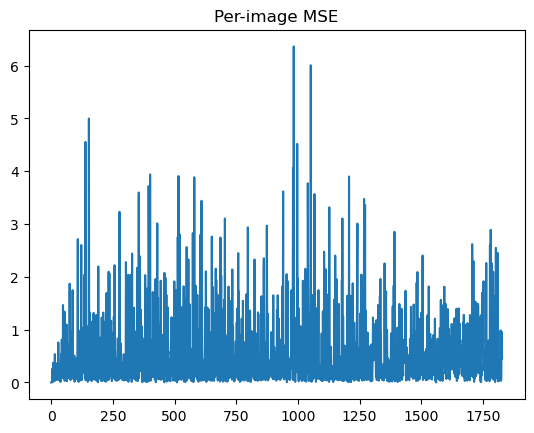

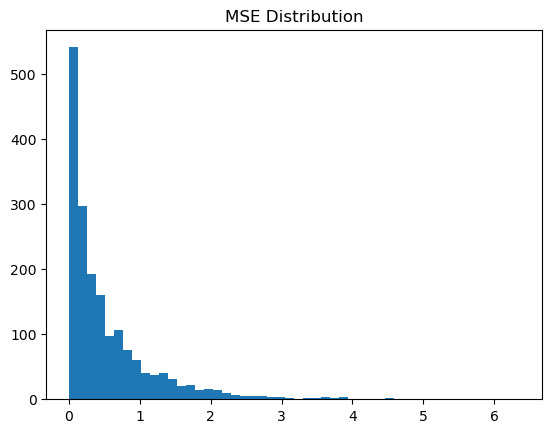

Saved per_image_mse.npy


In [75]:
baseline = np.load("baseline_3ddfa_expr.npy").squeeze(-1)
stored   = np.load("data/expressions.npy").squeeze(-1)

all_preds = baseline
all_gts   = stored

n = min(len(all_preds), len(all_gts))
all_preds = all_preds[:n]
all_gts   = all_gts[:n]

# -------------------------------
# Metrics
# -------------------------------
mse  = ((all_preds - all_gts)**2).mean()
mae  = np.abs(all_preds - all_gts).mean()
rmse = np.sqrt(mse)
r2   = r2_score(all_gts, all_preds)

print("\n======== GLOBAL METRICS ========")
print(f"MSE  : {mse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")

# -------------------------------
# Per parameter error
# -------------------------------
per_dim_mse = ((all_preds - all_gts)**2).mean(axis=0)
print("\n---- Per Parameter MSE ----")
for i, v in enumerate(per_dim_mse):
    print(f"Param {i}: {v:.6f}")

# -------------------------------
# Per-image MSE
# -------------------------------
per_image_mse = ((all_preds - all_gts)**2).mean(axis=1)
print("\nMean per-image MSE:", per_image_mse.mean())
print("Worst sample MSE:", per_image_mse.max())

plt.figure()
plt.plot(per_image_mse)
plt.title("Per-image MSE")
plt.show()

plt.figure()
plt.hist(per_image_mse, bins=50)
plt.title("MSE Distribution")
plt.show()

np.save("per_image_mse.npy", per_image_mse)
print("Saved per_image_mse.npy")